In [9]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer,CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif
import nltk
import pandas as pd
import numpy as np 
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics

In [2]:
# loading data
df = pd.read_csv('./Consumer_Complaints.csv')
df.shape

C:\Users\admin\AppData\Local\Temp\ipykernel_1700\98951488.py:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Consumer_Complaints.csv')


(670598, 18)

In [3]:

df['ZIP code']=df['ZIP code'].astype(str)
print(df.dtypes)

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object


In [4]:
df.head(2).T # Columns are shown in rows for easy reading


,0,1
Date received,07/29/2013,07/29/2013
Product,Consumer Loan,Bank account or service
Sub-product,Vehicle loan,Checking account
Issue,Managing the loan or lease,Using a debit or ATM card
Sub-issue,NaN,NaN
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,Wells Fargo & Company,Wells Fargo & Company
State,VA,CA
ZIP code,24540,95992


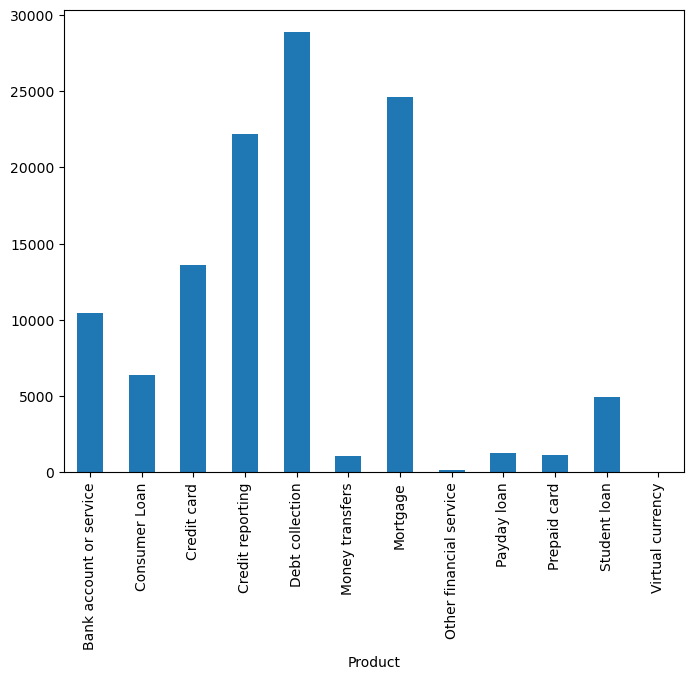

In [5]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar()
plt.show()

In [6]:
total = df['Consumer complaint narrative'].notnull().sum()
round((total/len(df)*100),1)

17.1

In [10]:
df.dtypes

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object

In [11]:
pd.notnull(df['Consumer complaint narrative']).value_counts()


False    555894
True     114704
Name: Consumer complaint narrative, dtype: int64

In [12]:
Data = df[['Product','Consumer complaint narrative']]
Data = Data[pd.notnull(Data['Consumer complaint narrative'])]
Data

,Product,Consumer complaint narrative
57729,Credit card,Received Capital One charge card offer XXXX. A...
57787,Debt collection,I do n't know how they got my cell number. I t...
57838,Credit card,I 'm a longtime member of Charter One Bank/RBS...
57848,Credit reporting,"After looking at my credit report, I saw a col..."
57852,Debt collection,I received a call from a XXXX XXXX from XXXX @...
...,...,...
670582,Mortgage,My mother XXXX in XXXX with a reverse mortgage...
670588,Credit card,Chase rejects customer payments claiming that ...
670590,Credit card,I filed for chapter XXXX protection 5 years ag...
670594,Mortgage,We purchased our home in XX/XX/XXXX at the pea...


In [13]:
Data.shape

(114704, 2)

In [14]:
Data = Data.sample(n=10000, random_state=42)


In [15]:
Data.groupby('Product')['Consumer complaint narrative'].count()


Product
Bank account or service     872
Consumer Loan               545
Credit card                1169
Credit reporting           1967
Debt collection            2477
Money transfers             103
Mortgage                   2199
Other financial service      16
Payday loan                 104
Prepaid card                 99
Student loan                448
Virtual currency              1
Name: Consumer complaint narrative, dtype: int64

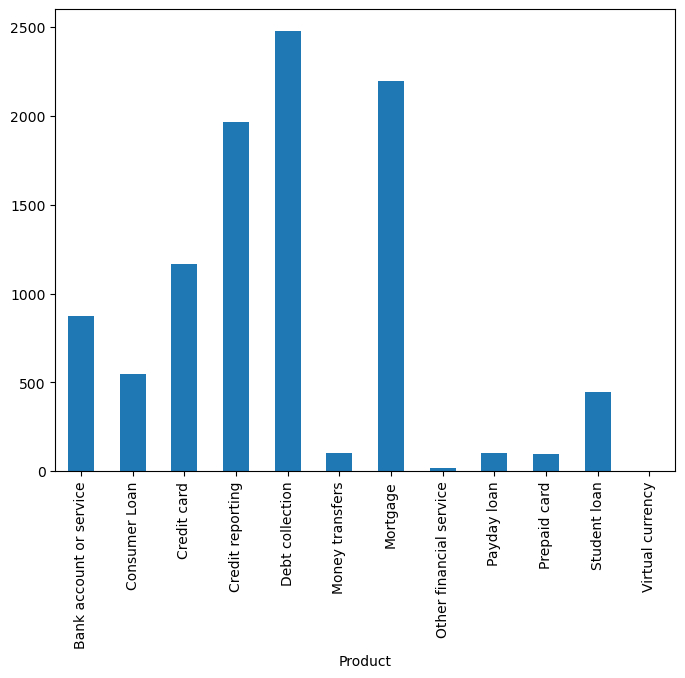

In [16]:
fig = plt.figure(figsize=(8,6))
Data.groupby('Product')['Consumer complaint narrative'].count().plot.bar()
plt.show()

# Pre processing

In [17]:
pd.DataFrame(df.Product.unique()).values


array([['Consumer Loan'],
       ['Bank account or service'],
       ['Mortgage'],
       ['Debt collection'],
       ['Credit card'],
       ['Credit reporting'],
       ['Student loan'],
       ['Money transfers'],
       ['Payday loan'],
       ['Other financial service'],
       ['Prepaid card'],
       ['Virtual currency']], dtype=object)

In [18]:
df2 = Data.sample(10000, random_state=1).copy()
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df2.head()

,Product,Consumer complaint narrative,category_id
583156,Bank account or service,"My name is XXXX XXXX. XXXX XXXX, XXXX I made a...",0
622141,Debt collection,I have attempted to obtain validation of this ...,1
64430,"Payday loan, title loan, or personal loan","Hello, This loan I borrowed from XXXX Cash on ...",2
517240,Mortgage,I own a condo in a building on the beach in XX...,3
234385,"Credit reporting, repair, or other",They have n't removed XXXX address where I hav...,4


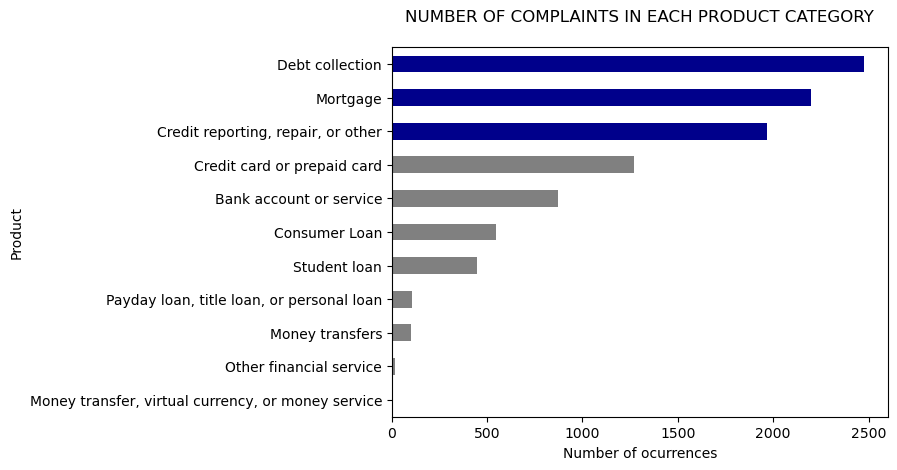

In [19]:
fig = plt.figure()
colors = ['grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product')['Consumer complaint narrative'].count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2['Consumer complaint narrative']).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 10000 complaints is represented by 26548 features (TF-IDF score of unigrams and bigrams)


In [21]:
X = df2['Consumer complaint narrative'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

train_x, valid_x,  train_y, valid_y = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

# Training 

In [30]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('selector', SelectKBest(f_classif, k=1000)),
    ('clf', DecisionTreeClassifier(criterion='gini', max_depth=15))
])

# Fit the GridSearchCV on the training data
pipeline.fit(train_x, train_y)



Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')),
                ('tfidf', TfidfTransformer()),
                ('selector', SelectKBest(k=1000)),
                ('clf', DecisionTreeClassifier(max_depth=25))])

Accuracy: 0.6744
Confusion Matrix:
[[136   9  27  17  19   0   3  12   1   1   0]
 [ 10  47   6  12  29   0   3  12   0   1   4]
 [ 32   3 186  29  49   0   1   5   0   2   3]
 [  6  18  15 352  75   0   1  21   0   0   3]
 [ 16  18  36  46 439   0   2  29   1   2  18]
 [  1   0   0   0   0   0   0   0   0   0   0]
 [  7   1   5   0   4   0   6   2   0   0   1]
 [ 14  10  14  19  36   0   3 452   1   1   6]
 [  1   0   0   0   3   0   0   0   0   0   0]
 [  1   4   1   4   3   0   0  11   0   3   2]
 [  7   8   5   5  23   0   1  13   0   0  65]]


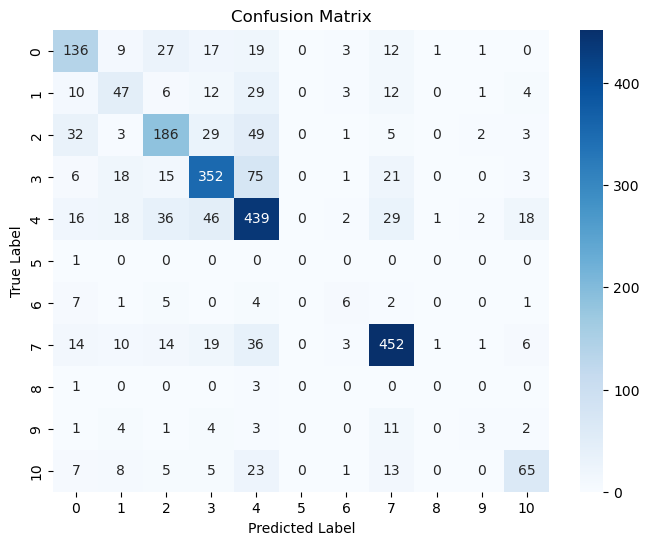

In [31]:

# Predict the labels for the validation data
predicted = pipeline.predict(valid_x)

# Calculate the accuracy
accuracy = accuracy_score(valid_y, predicted)
print("Accuracy:", accuracy)

# Print the confusion matrix
confusion_mat = confusion_matrix(valid_y, predicted)
print("Confusion Matrix:")
print(confusion_mat)
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
print("Classification Report:")
print(metrics.classification_report(valid_y, predicted))

Classification Report:
                                                    precision    recall  f1-score   support

                           Bank account or service       0.59      0.60      0.60       225
                                     Consumer Loan       0.40      0.38      0.39       124
                       Credit card or prepaid card       0.63      0.60      0.61       310
                Credit reporting, repair, or other       0.73      0.72      0.72       491
                                   Debt collection       0.65      0.72      0.68       607
Money transfer, virtual currency, or money service       0.00      0.00      0.00         1
                                   Money transfers       0.30      0.23      0.26        26
                                          Mortgage       0.81      0.81      0.81       556
                           Other financial service       0.00      0.00      0.00         4
         Payday loan, title loan, or personal loan      

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('selector', SelectKBest(f_classif, k=500)),
    ('clf', RandomForestClassifier(criterion='gini', max_depth=25,n_estimators=200))
])

# Fit the GridSearchCV on the training data
pipeline.fit(train_x, train_y)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')),
                ('tfidf', TfidfTransformer()), ('selector', SelectKBest(k=600)),
                ('clf',
                 RandomForestClassifier(max_depth=25, n_estimators=200))])

In [44]:

# Predict the labels for the validation data
predicted = pipeline.predict(valid_x)

# Calculate the accuracy
accuracy = accuracy_score(valid_y, predicted)
print("Accuracy:", accuracy)

# Print the confusion matrix
confusion_mat = confusion_matrix(valid_y, predicted)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.7796
Confusion Matrix:
[[161   0  30  13  12   0   0   8   0   0   1]
 [  4  40   6  13  36   0   0  23   0   0   2]
 [ 14   0 221  30  38   0   0   7   0   0   0]
 [  0   3   6 422  47   0   0  12   0   0   1]
 [  6   2  13  49 506   0   0  24   0   0   7]
 [  1   0   0   0   0   0   0   0   0   0   0]
 [  8   1   7   0   8   0   0   2   0   0   0]
 [  3   0   6  11  25   0   0 511   0   0   0]
 [  2   0   0   1   1   0   0   0   0   0   0]
 [  2   4   0   1  12   0   0   7   0   0   3]
 [  1   0   4   7  16   0   0  11   0   0  88]]


In [45]:
print("Classification Report:")
print(metrics.classification_report(valid_y, predicted))

Classification Report:
                                                    precision    recall  f1-score   support

                           Bank account or service       0.80      0.72      0.75       225
                                     Consumer Loan       0.80      0.32      0.46       124
                       Credit card or prepaid card       0.75      0.71      0.73       310
                Credit reporting, repair, or other       0.77      0.86      0.81       491
                                   Debt collection       0.72      0.83      0.77       607
Money transfer, virtual currency, or money service       0.00      0.00      0.00         1
                                   Money transfers       0.00      0.00      0.00        26
                                          Mortgage       0.84      0.92      0.88       556
                           Other financial service       0.00      0.00      0.00         4
         Payday loan, title loan, or personal loan      

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


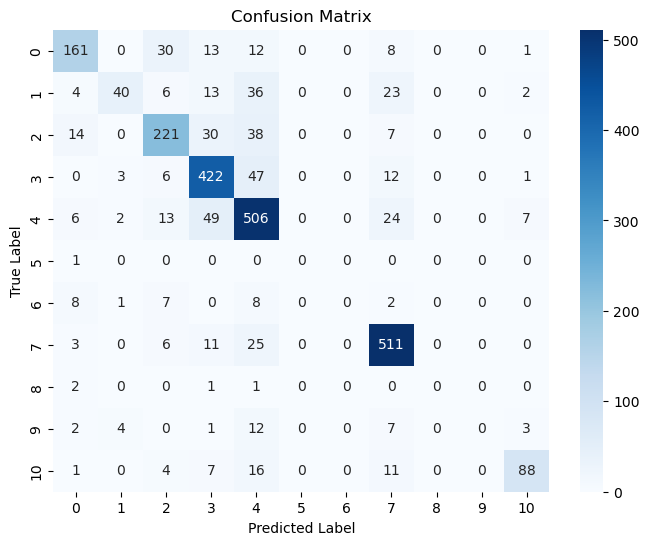

In [46]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('selector', SelectKBest(f_classif)),
    ('clf', DecisionTreeClassifier())
])

param_grid = {
    'selector__k': [1000,2000,3000],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 15,20,25,30],
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

# Fit the GridSearchCV on the training data
grid_search.fit(train_x, train_y)

# Access the results
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Extract the hyperparameters and scores
param_names = [str(param) for param in params]
x_pos = np.arange(len(param_names))
scores = np.array(mean_scores)
# Get the best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best model's parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Fit the best model on the training data
best_model.fit(train_x, train_y)

# Predict the labels for the validation data
predicted = best_model.predict(valid_x)

# Calculate the accuracy
accuracy = accuracy_score(valid_y, predicted)
print("Accuracy:", accuracy)

# Print the confusion matrix
confusion_mat = confusion_matrix(valid_y, predicted)
print("Confusion Matrix:")
print(confusion_mat)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline2 = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)),
    ('tfidf', TfidfTransformer()),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif,)),
    ('clf', RandomForestClassifier())
])

param_grid2 = {
    'feature_selection__k': [200,400,600,800,1000],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [15,20,25,30,35,40],
}

# Create a GridSearchCV instance
grid_search2 = GridSearchCV(pipeline2, param_grid=param_grid2, cv=5)

# Fit the GridSearchCV on the training data
grid_search2.fit(train_x, train_y)

# Access the results
results2 = grid_search2.cv_results_
params2 = results2['params']
mean_scores2 = results2['mean_test_score']

# Extract the hyperparameters and scores
param_names2 = [str(param) for param in params2]
x_pos2 = np.arange(len(param_names2))
scores2 = np.array(mean_scores2)
# Get the best model
best_model2 = grid_search2.best_estimator_
best_params2 = grid_search2.best_params_

# Print the best model's parameters
print("Best Parameters:")
for param, value in best_params2.items():
    print(f"{param}: {value}")

# Fit the best model on the training data
best_model2.fit(train_x, train_y)

# Predict the labels for the validation data
predicted2 = best_model2.predict(valid_x)

# Calculate the accuracy
accuracy2 = accuracy_score(valid_y, predicted2)
print("Accuracy:", accuracy2)

# Print the confusion matrix
confusion_mat2 = confusion_matrix(valid_y, predicted2)
print("Confusion Matrix:")
print(confusion_mat2)


In [47]:
complaint = ["""student school study college highschool loan"""
]
#text_features = tfidf_vect.transform(texts)
predictions = pipeline.predict(complaint)
# print(predictions)
print("   -Predicted as",predictions[0])

   -Predicted as Student loan


In [48]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

In [49]:
loaded_model = pickle.load(open(filename, 'rb'))


In [50]:
complaint = ["""student school  loan"""
]
#text_features = tfidf_vect.transform(texts)
predictions = loaded_model.predict(complaint)
# print(predictions)
print("   -Predicted as",predictions[0])

   -Predicted as Student loan
